In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (adjusted_rand_score, silhouette_score,davies_bouldin_score, calinski_harabasz_score)
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

✓ Setup complete!


📊 Dataset: 1797 samples, 64 features
📉 PCA explains 21.6% variance



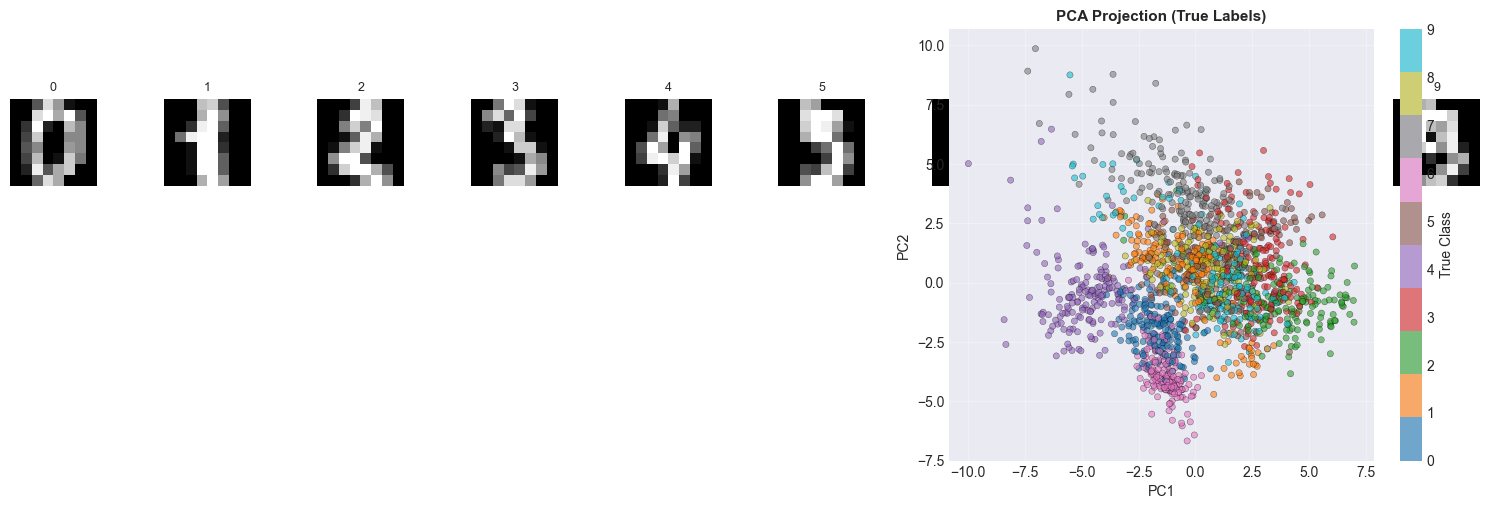

In [ ]:
digits = load_digits()
X, y_true = digits.data, digits.target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"📊 Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"📉 PCA explains {pca.explained_variance_ratio_.sum():.1%} variance\n")
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'{y_true[i]}', fontsize=9)
    ax.axis('off')
ax = plt.subplot(1, 2, 2)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='tab10', 
                    s=20, alpha=0.6, edgecolors='k', linewidth=0.3)
plt.colorbar(scatter, label='True Class')
ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_title('PCA Projection (True Labels)', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(9, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', 
                         s=20, alpha=0.6, edgecolors='k', linewidth=0.3)
    plt.colorbar(scatter, label='Cluster ID')
    plt.xlabel('PCA Component 1', fontsize=10)
    plt.ylabel('PCA Component 2', fontsize=10)
    plt.title(title, fontsize=11, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.sho
def evaluate_clustering(X, labels, y_true, name):
    mask = labels >= 0  
    return {
        'Algorithm': name,
        'ARI': adjusted_rand_score(y_true, labels),
        'Silhouette': silhouette_score(X[mask], labels[mask]) if mask.sum() > 1 else np.nan,
        'Davies-Bouldin': davies_bouldin_score(X[mask], labels[mask]) if mask.sum() > 1 else np.nan,
    }
print("✓ Helper functions ready!")

✓ Helper functions ready!


🔍 Finding optimal K using Elbow Method...



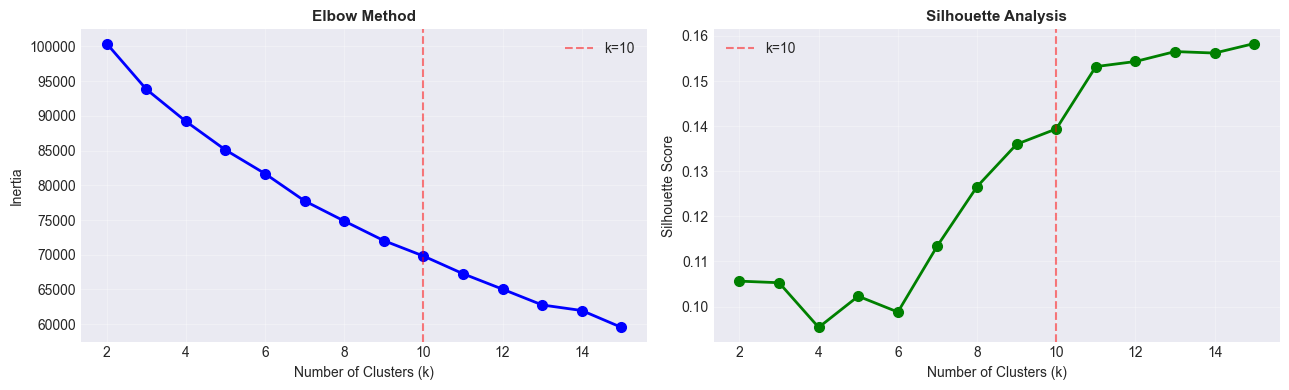

💡 Optimal K: 8-10 clusters


In [ ]:
print("🔍 Finding optimal K using Elbow Method...\n")
k_range = range(2, 16)
inertias, silhouettes = [], []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=7)
ax1.set_xlabel('Number of Clusters (k)', fontsize=10)
ax1.set_ylabel('Inertia', fontsize=10)
ax1.set_title('Elbow Method', fontsize=11, fontweight='bold')
ax1.axvline(x=10, color='r', linestyle='--', alpha=0.5, label='k=10')
ax1.legend()
ax1.grid(alpha=0.3)
ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=7)
ax2.set_xlabel('Number of Clusters (k)', fontsize=10)
ax2.set_ylabel('Silhouette Score', fontsize=10)
ax2.set_title('Silhouette Analysis', fontsize=11, fontweight='bold')
ax2.axvline(x=10, color='r', linestyle='--', alpha=0.5, label='k=10')
ax2.legend()
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("💡 Optimal K: 8-10 clusters")

🎯 Running K-Means with different K values...



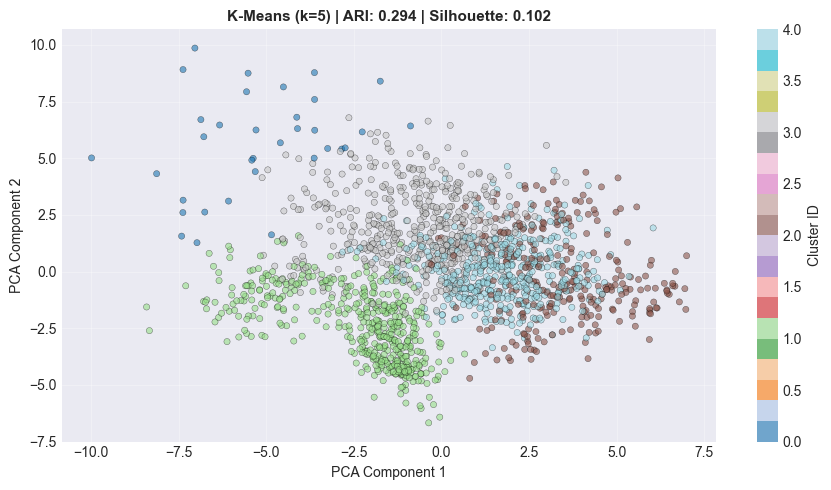

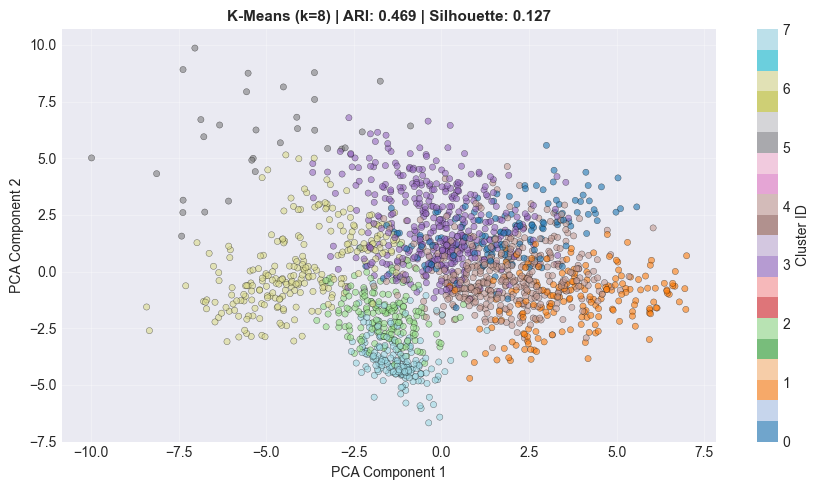

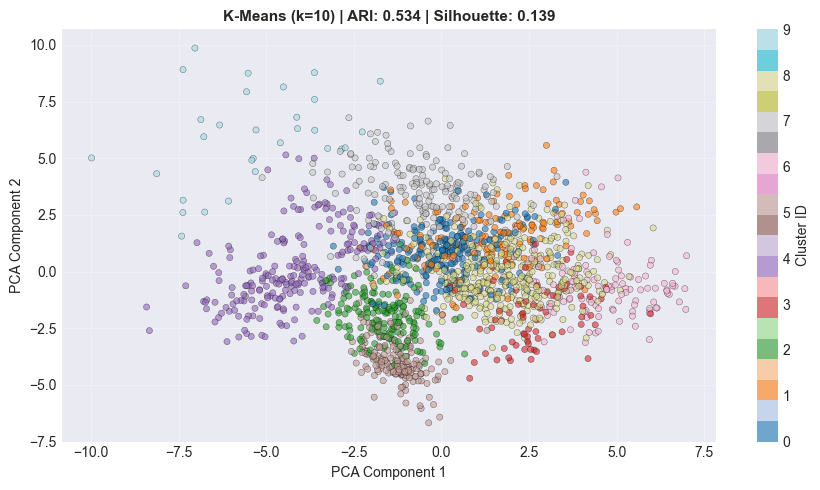

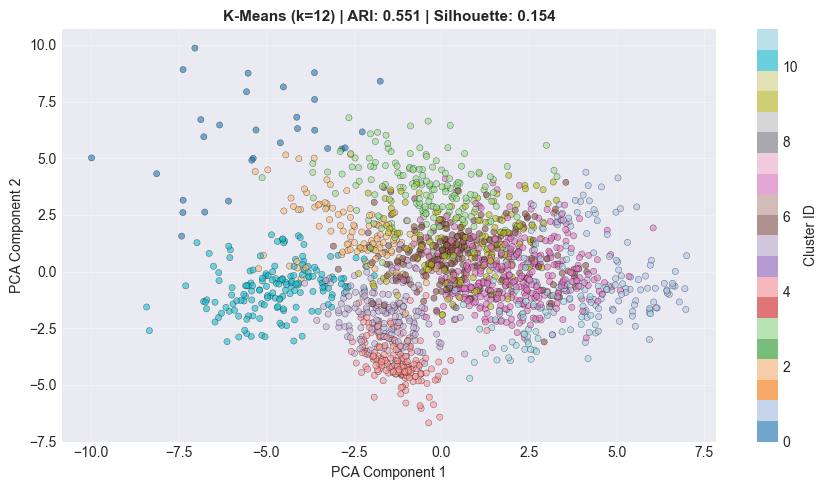

In [ ]:
print("🎯 Running K-Means with different K values...\n")
k_values = [5, 8, 10, 12]
kmeans_results = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    metrics = evaluate_clustering(X_scaled, labels, y_true, f'K-Means (k={k})')
    kmeans_results.append(metrics)
    plot_clusters(X_pca, labels,f'K-Means (k={k}) | ARI: {metrics["ARI"]:.3f} | Silhouette: {metrics["Silhouette"]:.3f}')

🌲 Hierarchical Clustering Analysis...



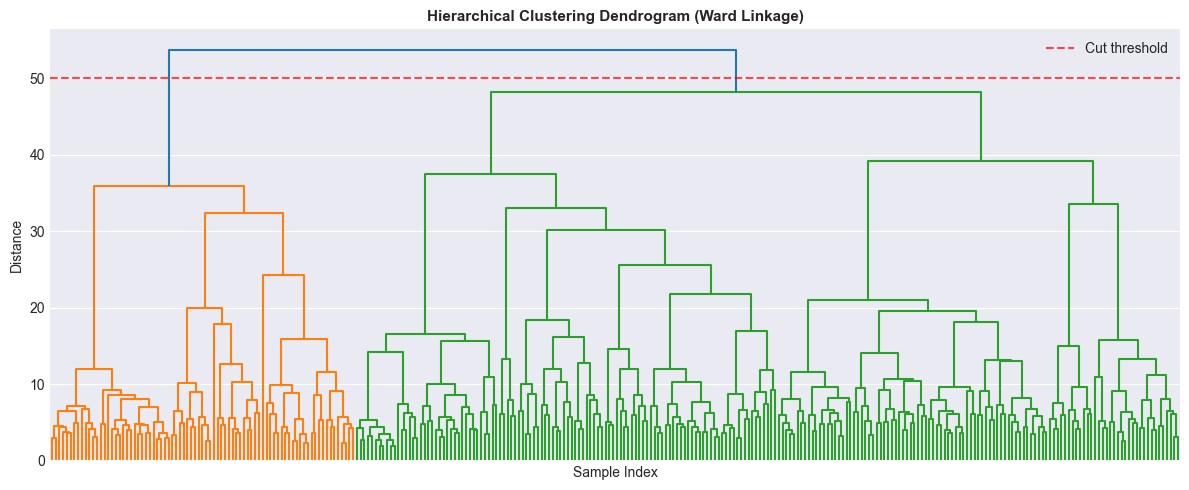

In [ ]:
print("🌲 Hierarchical Clustering Analysis...\n")
sample_indices = np.random.choice(X_scaled.shape[0], 300, replace=False)
linkage_matrix = linkage(X_scaled[sample_indices], method='ward')
plt.figure(figsize=(12, 5))
dendrogram(linkage_matrix, no_labels=True, color_threshold=50)
plt.xlabel('Sample Index', fontsize=10)
plt.ylabel('Distance', fontsize=10)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=11, fontweight='bold')
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7, label='Cut threshold')
plt.legend()
plt.tight_layout()
plt.show()

🔗 Running Agglomerative Clustering...



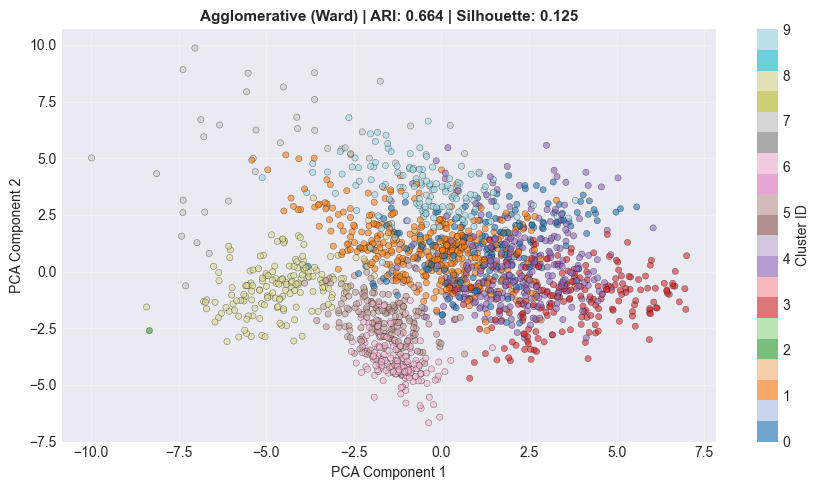

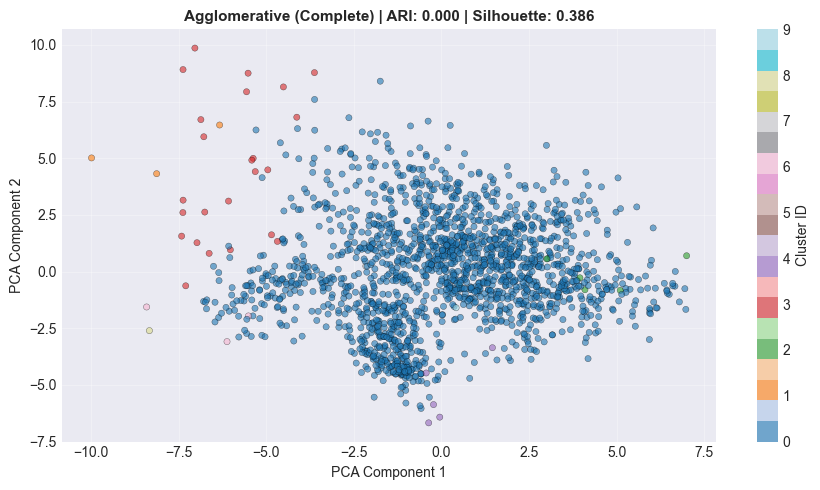

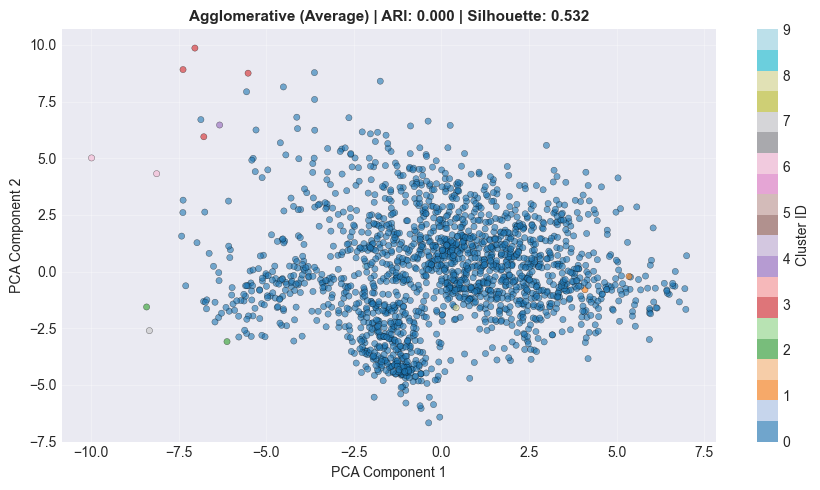

In [ ]:
print("🔗 Running Agglomerative Clustering...\n")
hierarchical_results = []
linkage_methods = ['ward', 'complete', 'average']
for method in linkage_methods:
    agglo = AgglomerativeClustering(n_clusters=10, linkage=method)
    labels = agglo.fit_predict(X_scaled)
    metrics = evaluate_clustering(X_scaled, labels, y_true, f'Hierarchical ({method})')
    hierarchical_results.append(metrics)
    plot_clusters(X_pca, labels, f'Agglomerative ({method.capitalize()}) | ARI: {metrics["ARI"]:.3f} | Silhouette: {metrics["Silhouette"]:.3f}')

🎲 DBSCAN Parameter Tuning...

eps=1.5: 0 clusters, 1797 noise (100.0%)
eps=2.0: 3 clusters, 1778 noise (98.9%)
eps=2.5: 2 clusters, 1756 noise (97.7%)
eps=3.0: 13 clusters, 1618 noise (90.0%)

🌌 Running DBSCAN with optimal parameters...



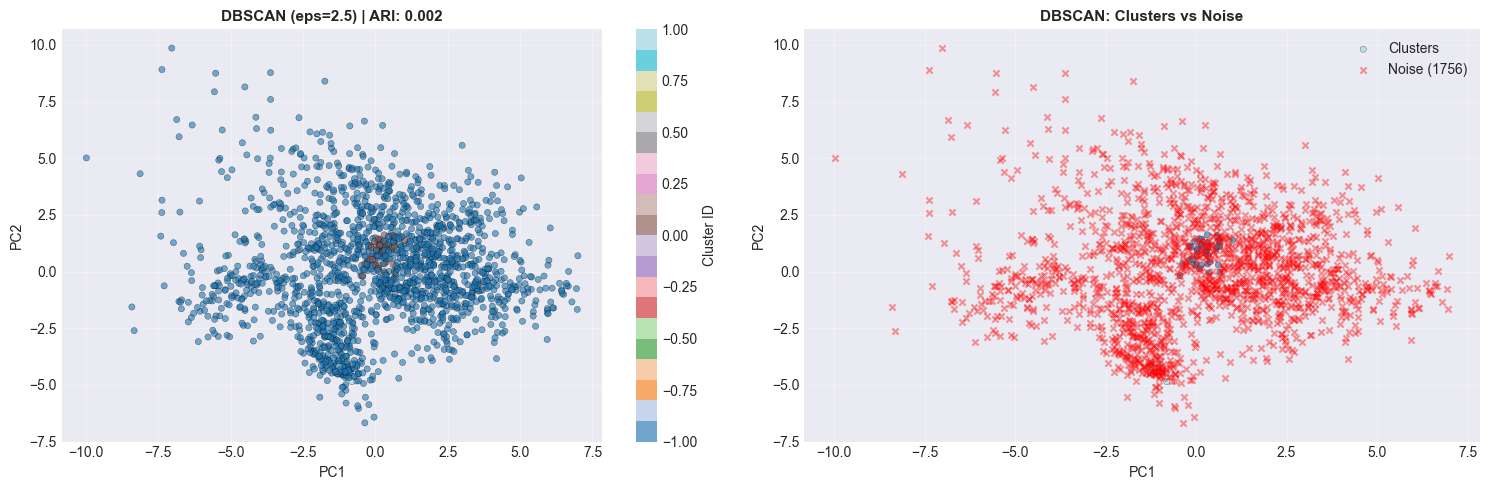

In [9]:
print("🎲 DBSCAN Parameter Tuning...\n")

# Test different eps values
eps_values = [1.5, 2.0, 2.5, 3.0]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise ({n_noise/len(labels)*100:.1f}%)")

print("\n🌌 Running DBSCAN with optimal parameters...\n")

# Final DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_metrics = evaluate_clustering(X_scaled, dbscan_labels, y_true, 'DBSCAN')

# Visualize with noise separation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# All points
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab20', 
                      s=20, alpha=0.6, edgecolors='k', linewidth=0.3)
ax1.set_xlabel('PC1', fontsize=10)
ax1.set_ylabel('PC2', fontsize=10)
ax1.set_title(f'DBSCAN (eps=2.5) | ARI: {dbscan_metrics["ARI"]:.3f}', 
              fontsize=11, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster ID')
ax1.grid(alpha=0.3)

# Noise separation
is_noise = dbscan_labels == -1
ax2.scatter(X_pca[~is_noise, 0], X_pca[~is_noise, 1], c=dbscan_labels[~is_noise], 
           cmap='tab20', s=20, alpha=0.6, edgecolors='k', linewidth=0.3, label='Clusters')
ax2.scatter(X_pca[is_noise, 0], X_pca[is_noise, 1], c='red', 
           s=20, alpha=0.4, marker='x', label=f'Noise ({is_noise.sum()})')
ax2.set_xlabel('PC1', fontsize=10)
ax2.set_ylabel('PC2', fontsize=10)
ax2.set_title('DBSCAN: Clusters vs Noise', fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
print("📊 PERFORMANCE COMPARISON\n")

# Combine results
all_results = kmeans_results + hierarchical_results + [dbscan_metrics]
results_df = pd.DataFrame(all_results)

print("=" * 70)
print(results_df.to_string(index=False, float_format='%.4f'))
print("=" * 70)

print(f"\n🏆 Best ARI: {results_df.loc[results_df['ARI'].idxmax(), 'Algorithm']} "
      f"({results_df['ARI'].max():.4f})")
print(f"🏆 Best Silhouette: {results_df.loc[results_df['Silhouette'].idxmax(), 'Algorithm']} "
      f"({results_df['Silhouette'].max():.4f})")
print(f"🏆 Best Davies-Bouldin: {results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'Algorithm']} "
      f"({results_df['Davies-Bouldin'].min():.4f})")


📊 PERFORMANCE COMPARISON

              Algorithm    ARI  Silhouette  Davies-Bouldin
          K-Means (k=5) 0.2942      0.1023          2.2529
          K-Means (k=8) 0.4687      0.1266          2.0162
         K-Means (k=10) 0.5344      0.1394          1.8770
         K-Means (k=12) 0.5512      0.1543          1.7207
    Hierarchical (ward) 0.6643      0.1253          1.9672
Hierarchical (complete) 0.0003      0.3857          0.6865
 Hierarchical (average) 0.0000      0.5317          0.4405
                 DBSCAN 0.0015      0.6787          0.4220

🏆 Best ARI: Hierarchical (ward) (0.6643)
🏆 Best Silhouette: DBSCAN (0.6787)
🏆 Best Davies-Bouldin: DBSCAN (0.4220)



📈 Visualizing Performance...



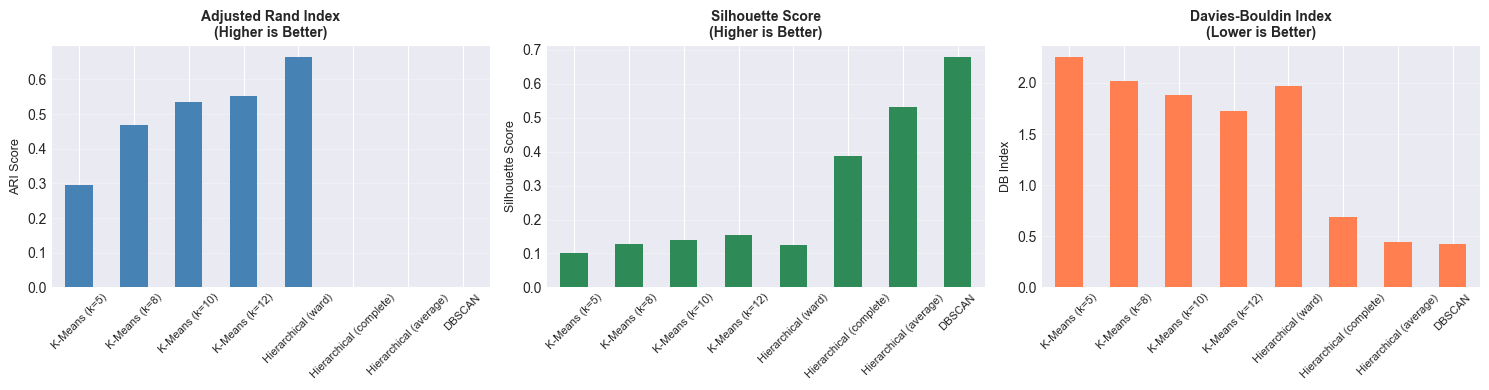

In [11]:
print("\n📈 Visualizing Performance...\n")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ARI
results_df.plot(x='Algorithm', y='ARI', kind='bar', ax=axes[0], 
               color='steelblue', legend=False)
axes[0].set_title('Adjusted Rand Index\n(Higher is Better)', fontsize=10, fontweight='bold')
axes[0].set_ylabel('ARI Score', fontsize=9)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0].grid(axis='y', alpha=0.3)

# Silhouette
results_df.plot(x='Algorithm', y='Silhouette', kind='bar', ax=axes[1], 
               color='seagreen', legend=False)
axes[1].set_title('Silhouette Score\n(Higher is Better)', fontsize=10, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=9)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)
axes[1].grid(axis='y', alpha=0.3)

# Davies-Bouldin
results_df.plot(x='Algorithm', y='Davies-Bouldin', kind='bar', ax=axes[2], 
               color='coral', legend=False)
axes[2].set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=10, fontweight='bold')
axes[2].set_ylabel('DB Index', fontsize=9)
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=45, labelsize=8)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()